In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset

In [3]:
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64

transform = transforms.ToTensor()
mnist_train_data = MNIST(root='data', train=True, download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_data, num_workers=num_workers, batch_size=batch_size)

f_mnist_train_data = FashionMNIST(root='data', train=True, download=True, transform=transform)
f_mnist_train_loader = torch.utils.data.DataLoader(f_mnist_train_data, num_workers=num_workers, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



tensor(9)


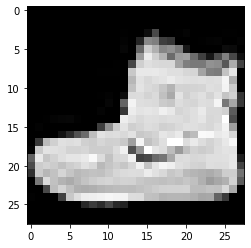

In [4]:
data_iter = iter(f_mnist_train_loader)
images, labels = data_iter.next()
images = images.numpy()

img = np.squeeze(images[0])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

print(labels[0])

# GAN Model

In [5]:
import torch.nn as nn
import torch.nn.functional as func

class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*3)  # 784 x hidden_size1
        self.fc2 = nn.Linear(hidden_dim*3, hidden_dim*2)
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*2, n_outputs)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 784)   # batch_size x (28*28)
        
        # hidden layers
        x = self.fc1(func.leaky_relu(x, 0.2))
        x = self.dropout(x)
        x = self.fc2(func.leaky_relu(x, 0.2))
        x = self.dropout(x)

        # final layer
        out = self.fc3(x)   # batch_size x 1
        
        return out

In [6]:
class Generator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(Generator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*2)  # z_size
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim*3)
        self.batch_norm = nn.BatchNorm1d(hidden_dim*3, 0.8)
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*3, n_outputs)
        
        # dropout
        self.dropout = nn.Dropout(0.3)

        
        
    def forward(self, x):
        
        # hidden layers
        x = self.fc1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
     
        # output
        out = func.tanh(self.fc3(x))  # batch_size x (28*28)
        
        return out

# Training

In [7]:
# Discriminator hyperparams
d_input_size = 784        # image_size
d_output_size = 1       # real or fake
d_hidden_size = 64

# Generator hyperparams
z_size = 64             # Size of latent vector
g_output_size = 784     # image_size
g_hidden_size = 64

In [8]:
D = Discriminator(d_input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=192, bias=True)
  (batch_norm): BatchNorm1d(192, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=192, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [9]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size) 
    # One-sided label smoothing
    labels = labels - 0.1     # real labels = 0.9
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [10]:
import torch.optim as optim

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [11]:
import pickle as pkl

num_epochs = 100
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=32
fixed_z = torch.Tensor(np.random.uniform(-1, 1, (sample_size, z_size)))

D.train()
G.train()
for epoch in range(num_epochs):
    for batch, (real_images, _) in enumerate(f_mnist_train_loader):
        
        batch_size = real_images.size(0)
        
        # rescale input images from [0,1) to [-1, 1)
        real_images = real_images*2 - 1  
        
        # TRAIN THE DISCRIMINATOR
        d_optimizer.zero_grad()
        
        # 1. Train with real images
        D_out_real = D(real_images)
        d_real_loss = real_loss(D_out_real)
        
        # 2. Train with fake images
        # Generate fake images
        with torch.no_grad():
            z = torch.Tensor(np.random.uniform(-1, 1, (batch_size, z_size)))
            fake_images = G(z)
        # loss on fake images
        D_out_fake = D(fake_images)
        d_fake_loss = fake_loss(D_out_fake)
        
        # 3. Add up loss
        d_loss = d_real_loss + d_fake_loss

        # backprop
        d_loss.backward()
        d_optimizer.step()
        
        # TRAIN THE GENERATOR
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = torch.Tensor(np.random.uniform(-1, 1, (batch_size, z_size)))
        fake_images = G(z)
        
        D_out_fake = D(fake_images)
        g_loss = real_loss(D_out_fake) # use real loss to flip labels
        
        # backprop
        g_loss.backward()
        g_optimizer.step()


        if batch % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:.4f} | g_loss: {:.4f}'.format(
                epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))

    # generate and save samples
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3748 | g_loss: 0.7315
Epoch [    1/  100] | d_loss: 0.4186 | g_loss: 2.6826
Epoch [    1/  100] | d_loss: 0.5245 | g_loss: 3.5358
Epoch [    2/  100] | d_loss: 0.4289 | g_loss: 3.4745
Epoch [    2/  100] | d_loss: 0.4403 | g_loss: 4.2963
Epoch [    2/  100] | d_loss: 0.5631 | g_loss: 2.8560
Epoch [    3/  100] | d_loss: 0.5473 | g_loss: 2.8819
Epoch [    3/  100] | d_loss: 0.5040 | g_loss: 2.4789
Epoch [    3/  100] | d_loss: 0.6049 | g_loss: 2.5718
Epoch [    4/  100] | d_loss: 0.5533 | g_loss: 2.5469
Epoch [    4/  100] | d_loss: 0.6906 | g_loss: 2.4399
Epoch [    4/  100] | d_loss: 0.7830 | g_loss: 2.1127
Epoch [    5/  100] | d_loss: 0.8853 | g_loss: 1.9364
Epoch [    5/  100] | d_loss: 0.8003 | g_loss: 2.1030
Epoch [    5/  100] | d_loss: 0.7632 | g_loss: 1.6879
Epoch [    6/  100] | d_loss: 0.9443 | g_loss: 1.8270
Epoch [    6/  100] | d_loss: 0.8148 | g_loss: 1.8816
Epoch [    6/  100] | d_loss: 0.8242 | g_loss: 2.0295
Epoch [    7/  100] | d_loss

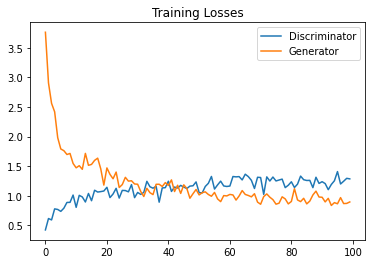

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Sample

## Training sample

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

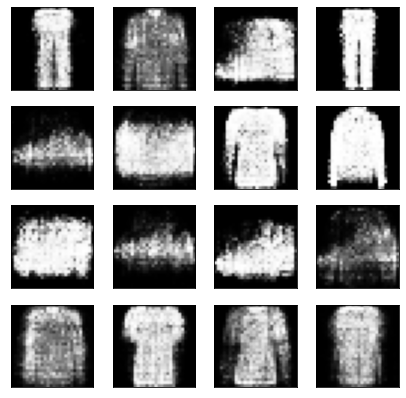

In [15]:
view_samples(-1, samples)

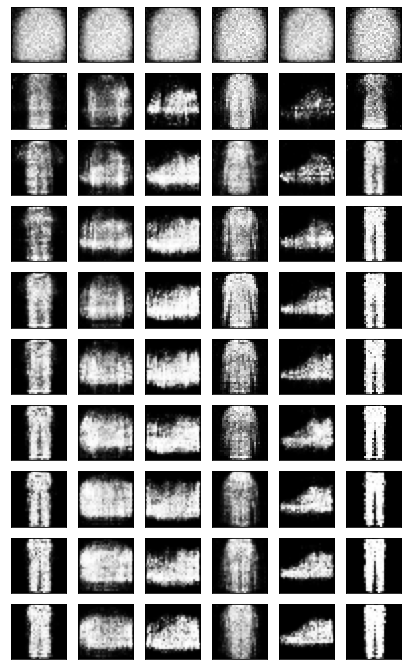

In [16]:
rows = 10 # show every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Result sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


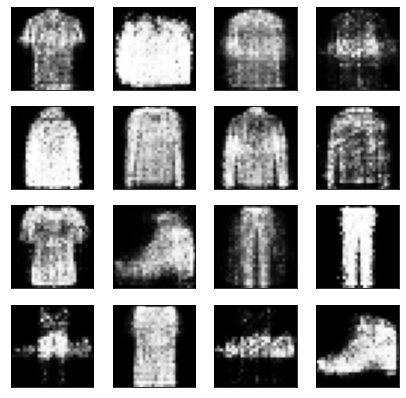

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])